In [607]:
import pandas as pd

In [608]:
raw = pd.read_csv('BT-Picks.csv', header=None)
raw.columns = ["date", "day", "pick", "secondary_pick"]
raw = raw.drop(columns='secondary_pick')
raw.head()

,date,day,pick
0,12/1/20,Tuesday,Eagle Rare
1,12/2/20,Wednesday,E.H. Taylor Jr. Small Batch
2,12/3/20,Thursday,Blanton’s
3,12/4/20,Friday,Single Oak Project
4,12/5/20,Saturday,Eagle Rare


In [609]:
#Converting the date column to numeric and creating new features

# Convert 'date' column to datetime using pd.to_datetime()
raw['date'] = pd.to_datetime(raw['date'])

# Create a 'week' column using the isocalendar week method
raw['week'] = raw['date'].dt.isocalendar().week

# Corrected: use .dt.month to get the month
raw['month'] = raw['date'].dt.month

# Create a 'year' column using the isocalendar year method
raw['year'] = raw['date'].dt.isocalendar().year

# Corrected: use 'date' instead of 'date_column'
raw['day'] = raw['date'].dt.day
raw['day_of_week'] = raw['date'].dt.dayofweek


# Display the first few rows
raw.head()


/var/folders/wb/stch18dn2z1gw9s72md26f740000gn/T/ipykernel_25169/2786939293.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  raw['date'] = pd.to_datetime(raw['date'])


,date,day,pick,week,month,year,day_of_week
0,2020-12-01,1,Eagle Rare,49,12,2020,1
1,2020-12-02,2,E.H. Taylor Jr. Small Batch,49,12,2020,2
2,2020-12-03,3,Blanton’s,49,12,2020,3
3,2020-12-04,4,Single Oak Project,49,12,2020,4
4,2020-12-05,5,Eagle Rare,49,12,2020,5


In [610]:
#I need to make sure that the arent duplicate names for each of the picks before doing one hot encoding
raw['pick'].value_counts()



pick
Blanton’s                       388
W.L. Weller Special Reserve     336
E.H. Taylor, Jr. Small Batch    309
Eagle Rare                      280
Sazerac Rye                      46
Closed                           13
CLOSED                           10
E.H. Taylor Jr. Small Batch       7
Single Oak Project                6
Weller Special Reserve            5
Closed – Holiday                  3
Name: count, dtype: int64

In [611]:
#problem names: CLOSED -> Closed, E.H. Taylor Jr. Small Batch -> E.H. Taylor, Jr. Small Batch, Weller Special Reserve -> W.L. Weller Special Reserve, Closed – Holiday -> Closed

# Replacement dictionary
replace_dict = {
    'CLOSED': 'Closed',
    'E.H. Taylor Jr. Small Batch': 'E.H. Taylor, Jr. Small Batch',
    'Weller Special Reserve': 'W.L. Weller Special Reserve',
    'Closed – Holiday': 'Closed',
    "Blanton's": 'Blantons'  # This is the key to check
}

# Ensure all values in the 'pick' column are strings and strip any spaces
raw['pick'] = raw['pick'].astype(str).str.strip()

# Replace values in the 'pick' column
raw['pick'] = raw['pick'].replace(replace_dict)

# Display the value counts to check the results
raw['pick'].value_counts()

# some dirty rows still exist for july 4th that dont have a pick. we will just change these to closed for the pick. 
raw['pick'] = raw['pick'].replace('nan', 'Closed')

#looks alot better

In [612]:
raw['pick'].value_counts()

pick
Blanton’s                       388
W.L. Weller Special Reserve     341
E.H. Taylor, Jr. Small Batch    316
Eagle Rare                      280
Sazerac Rye                      46
Closed                           28
Single Oak Project                6
Name: count, dtype: int64

In [613]:
# They no longer give out Sazerac Rye or the One Oak Project out as allocations. 
# We need to count the number of rows that have these values and we need to get rid of them.

not_allocated_anymore = raw['pick'].isin(['Single Oak Project', 'Sazerac Rye']).sum()
print(f"Number of rows with 'Single Oak Project' or 'Sazerac Rye' in picks: {not_allocated_anymore}")


Number of rows with 'Single Oak Project' or 'Sazerac Rye' in picks: 52


In [614]:
#Creating a new column that only contains past allocations that align with current allocations
allocation_data = raw[~raw['pick'].isin(['Single Oak Project', 'Sazerac Rye'])]
allocation_data['pick'].value_counts()

pick
Blanton’s                       388
W.L. Weller Special Reserve     341
E.H. Taylor, Jr. Small Batch    316
Eagle Rare                      280
Closed                           28
Name: count, dtype: int64

In [615]:
allocation_data.head()

,date,day,pick,week,month,year,day_of_week
0,2020-12-01,1,Eagle Rare,49,12,2020,1
1,2020-12-02,2,"E.H. Taylor, Jr. Small Batch",49,12,2020,2
2,2020-12-03,3,Blanton’s,49,12,2020,3
4,2020-12-05,5,Eagle Rare,49,12,2020,5
5,2020-12-06,6,Blanton’s,49,12,2020,6


## Feature Engineering
- Is it the weekend?
- What quarter is it?
- Lagged values (1 day, 7 day, 14 day)
- Season

In [616]:
# Weekend Value
allocation_data['is_weekend'] = allocation_data['date'].dt.weekday.isin([5, 6]).astype(int)

#Quarter value

allocation_data['quarter'] = allocation_data['date'].dt.quarter

# Lagged columns
# Create lagged value columns
allocation_data.loc[:, 'lag_1'] = allocation_data['pick'].shift(1)   # 1-day lag
allocation_data.loc[:, 'lag_7'] = allocation_data['pick'].shift(7)   # 7-day lag
allocation_data.loc[:, 'lag_14'] = allocation_data['pick'].shift(14) # 14-day lag

/var/folders/wb/stch18dn2z1gw9s72md26f740000gn/T/ipykernel_25169/1534465366.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  allocation_data['is_weekend'] = allocation_data['date'].dt.weekday.isin([5, 6]).astype(int)
/var/folders/wb/stch18dn2z1gw9s72md26f740000gn/T/ipykernel_25169/1534465366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  allocation_data['quarter'] = allocation_data['date'].dt.quarter
/var/folders/wb/stch18dn2z1gw9s72md26f740000gn/T/ipykernel_25169/1534465366.py:10: SettingWithCopyWa

In [617]:
# I only want to include rows that have all three lag variables, that isthere are no none. This will take out the first 14 rows of data. 

allocation_data = allocation_data[14:]
allocation_data.head()


,date,day,pick,week,month,year,day_of_week,is_weekend,quarter,lag_1,lag_7,lag_14
16,2020-12-17,17,W.L. Weller Special Reserve,51,12,2020,3,0,4,Eagle Rare,"E.H. Taylor, Jr. Small Batch",Eagle Rare
17,2020-12-18,18,"E.H. Taylor, Jr. Small Batch",51,12,2020,4,0,4,W.L. Weller Special Reserve,W.L. Weller Special Reserve,"E.H. Taylor, Jr. Small Batch"
18,2020-12-19,19,W.L. Weller Special Reserve,51,12,2020,5,1,4,"E.H. Taylor, Jr. Small Batch",W.L. Weller Special Reserve,Blanton’s
19,2020-12-20,20,Blanton’s,51,12,2020,6,1,4,W.L. Weller Special Reserve,Blanton’s,Eagle Rare
20,2020-12-21,21,Blanton’s,52,12,2020,0,0,4,Blanton’s,Eagle Rare,Blanton’s


In [618]:
# Assuming you have a 'date' column of type datetime
allocation_data['season'] = allocation_data['date'].apply(lambda x: (x.month % 12 + 3) // 3)


This next code block is where I left off
- I need to create encoding for the picks so that I can create running total features to add to the dataset. 

In [622]:
from sklearn.preprocessing import LabelEncoder

# Convert categorical target variable to numeric
label_encoder = LabelEncoder()
allocation_data['pick_labled'] = label_encoder.fit_transform(allocation_data['pick'])

# Assuming 'month' is a categorical feature and 'pick' is the numeric target variable
allocation_data['month_target_mean'] = allocation_data.groupby('month')['pick'].transform('mean')



# # Example: Count the previous occurrences of each class over the past 7 days
# allocation_data['pick_last_week'] = allocation_data['pick'].rolling(window=7).apply(lambda x: (x == allocation_data['pick']).sum(), raw=True)


TypeError: Could not convert ClosedW.L. Weller Special ReserveW.L. Weller Special ReserveBlanton’sEagle RareE.H. Taylor, Jr. Small BatchW.L. Weller Special ReserveE.H. Taylor, Jr. Small BatchBlanton’sE.H. Taylor, Jr. Small BatchEagle RareW.L. Weller Special ReserveBlanton’sW.L. Weller Special ReserveE.H. Taylor, Jr. Small BatchBlanton’sW.L. Weller Special ReserveBlanton’sE.H. Taylor, Jr. Small BatchW.L. Weller Special ReserveBlanton’sW.L. Weller Special ReserveE.H. Taylor, Jr. Small BatchBlanton’sEagle RareW.L. Weller Special ReserveBlanton’sE.H. Taylor, Jr. Small BatchW.L. Weller Special ReserveE.H. Taylor, Jr. Small BatchClosedE.H. Taylor, Jr. Small BatchEagle RareEagle RareW.L. Weller Special ReserveBlanton’sE.H. Taylor, Jr. Small BatchW.L. Weller Special ReserveEagle RareBlanton’sE.H. Taylor, Jr. Small BatchEagle RareEagle RareW.L. Weller Special ReserveE.H. Taylor, Jr. Small BatchBlanton’sW.L. Weller Special ReserveE.H. Taylor, Jr. Small BatchW.L. Weller Special ReserveE.H. Taylor, Jr. Small BatchBlanton’sEagle RareBlanton’sClosedW.L. Weller Special ReserveBlanton’sE.H. Taylor, Jr. Small BatchEagle RareBlanton’sE.H. Taylor, Jr. Small BatchW.L. Weller Special ReserveE.H. Taylor, Jr. Small BatchEagle RareW.L. Weller Special ReserveBlanton’sE.H. Taylor, Jr. Small BatchW.L. Weller Special ReserveEagle RareBlanton’sE.H. Taylor, Jr. Small BatchW.L. Weller Special ReserveBlanton’sE.H. Taylor, Jr. Small BatchBlanton’sW.L. Weller Special ReserveE.H. Taylor, Jr. Small BatchBlanton’sEagle RareW.L. Weller Special ReserveE.H. Taylor, Jr. Small BatchW.L. Weller Special ReserveBlanton’sE.H. Taylor, Jr. Small BatchBlanton’sClosedBlanton’sEagle RareW.L. Weller Special ReserveBlanton’sE.H. Taylor, Jr. Small BatchW.L. Weller Special ReserveBlanton’sEagle RareW.L. Weller Special ReserveE.H. Taylor, Jr. Small BatchW.L. Weller Special ReserveBlanton’sEagle RareBlanton’sW.L. Weller Special ReserveEagle RareE.H. Taylor, Jr. Small BatchBlanton’sW.L. Weller Special ReserveE.H. Taylor, Jr. Small BatchW.L. Weller Special ReserveEagle RareBlanton’sW.L. Weller Special ReserveE.H. Taylor, Jr. Small BatchBlanton’sW.L. Weller Special ReserveE.H. Taylor, Jr. Small BatchBlanton’sW.L. Weller Special Reserve to numeric

In [583]:
# One hot enconding the lag columns to help with model training. 

allocation_data_encoded = pd.get_dummies(allocation_data, columns=['lag_1', 'lag_7', 'lag_14'], drop_first=True)

allocation_data_encoded[allocation_data_encoded.columns[-(3*5):]] = allocation_data_encoded[allocation_data_encoded.columns[-(3*5):]].astype(int)

allocation_data_encoded.head()

,date,day,pick,week,month,year,day_of_week,is_weekend,quarter,season,...,lag_1_Eagle Rare,lag_1_W.L. Weller Special Reserve,lag_7_Closed,"lag_7_E.H. Taylor, Jr. Small Batch",lag_7_Eagle Rare,lag_7_W.L. Weller Special Reserve,lag_14_Closed,"lag_14_E.H. Taylor, Jr. Small Batch",lag_14_Eagle Rare,lag_14_W.L. Weller Special Reserve
16,2020-12-17,17,W.L. Weller Special Reserve,51,12,2020,3,0,4,1,...,1,0,0,1,0,0,0,0,1,0
17,2020-12-18,18,"E.H. Taylor, Jr. Small Batch",51,12,2020,4,0,4,1,...,0,1,0,0,0,1,0,1,0,0
18,2020-12-19,19,W.L. Weller Special Reserve,51,12,2020,5,1,4,1,...,0,0,0,0,0,1,0,0,0,0
19,2020-12-20,20,Blanton’s,51,12,2020,6,1,4,1,...,0,1,0,0,0,0,0,0,1,0
20,2020-12-21,21,Blanton’s,52,12,2020,0,0,4,1,...,0,0,0,0,1,0,0,0,0,0


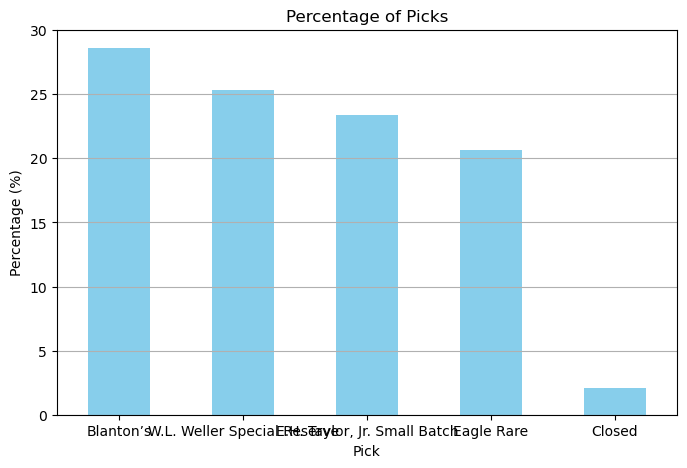

In [584]:
# Need to look at the balance of the classes to determine what to use as a metric, ROC or Accuracy

class_proportions = allocation_data_encoded['pick'].value_counts(normalize=True) * 100  # Convert to percentage

# Plotting
plt.figure(figsize=(8, 5))
class_proportions.plot(kind='bar', color='skyblue')
plt.title('Percentage of Picks')
plt.xlabel('Pick')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)
plt.grid(axis='y')

# Show the plot
plt.show()

In [585]:
model_data = allocation_data_encoded.drop(columns='date')

In [586]:
model_data.shape

(1339, 21)

In [587]:
model_data.head()

,day,pick,week,month,year,day_of_week,is_weekend,quarter,season,lag_1_Closed,...,lag_1_Eagle Rare,lag_1_W.L. Weller Special Reserve,lag_7_Closed,"lag_7_E.H. Taylor, Jr. Small Batch",lag_7_Eagle Rare,lag_7_W.L. Weller Special Reserve,lag_14_Closed,"lag_14_E.H. Taylor, Jr. Small Batch",lag_14_Eagle Rare,lag_14_W.L. Weller Special Reserve
16,17,W.L. Weller Special Reserve,51,12,2020,3,0,4,1,0,...,1,0,0,1,0,0,0,0,1,0
17,18,"E.H. Taylor, Jr. Small Batch",51,12,2020,4,0,4,1,0,...,0,1,0,0,0,1,0,1,0,0
18,19,W.L. Weller Special Reserve,51,12,2020,5,1,4,1,0,...,0,0,0,0,0,1,0,0,0,0
19,20,Blanton’s,51,12,2020,6,1,4,1,0,...,0,1,0,0,0,0,0,0,1,0
20,21,Blanton’s,52,12,2020,0,0,4,1,0,...,0,0,0,0,1,0,0,0,0,0


# Logistic Regression

In [588]:
# OVR General Model

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score


# Assuming model_data is already loaded
X = model_data.drop(columns=['pick'])  # Features
y = model_data['pick']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize One-vs-Rest logistic regression
ovr_model = OneVsRestClassifier(LogisticRegression(max_iter=1000))

# Fit the model on the training data
ovr_model.fit(X_train, y_train)


# Predict on test set
y_pred = ovr_model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.39552238805970147


In [589]:
from sklearn.model_selection import GridSearchCV

# Set up parameter grid for hyperparameter tuning
param_grid = {
    'estimator__C': [0.01, 0.1, 1, 10],
    'estimator__solver': ['liblinear', 'saga', 'lbfgs']
}

# Grid search with cross-validation
grid_search = GridSearchCV(
    OneVsRestClassifier(LogisticRegression(max_iter=1000)),
    param_grid,
    cv=5,
    scoring='accuracy'
)
grid_search.fit(X, y)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)


/Users/jackguptill/anaconda3/envs/minimal_ds/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jackguptill/anaconda3/envs/minimal_ds/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jackguptill/anaconda3/envs/minimal_ds/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jackguptill/anaconda3/envs/minimal_ds/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jackguptill/anaconda3/envs/minimal_ds/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means

Best Parameters: {'estimator__C': 10, 'estimator__solver': 'liblinear'}
Best Cross-Validation Score: 0.37638492928615347


In [590]:
# Perform cross-validation
cv_scores = cross_val_score(ovr_model, X, y, cv=5, scoring='accuracy')  # Use 'accuracy' as the metric
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())
print("Standard Deviation of CV Scores:", cv_scores.std())

Cross-Validation Scores: [0.35820896 0.38059701 0.38432836 0.39179104 0.35205993]
Mean CV Score: 0.3733970596455923
Standard Deviation of CV Scores: 0.01546365519602343


In [591]:
from sklearn.ensemble import VotingClassifier

# Example ensemble with logistic regression, random forest, and SVM
ensemble_model = VotingClassifier(
    estimators=[
        ('lr', OneVsRestClassifier(LogisticRegression(max_iter=1000))),
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('svm', OneVsRestClassifier(SVC(kernel='linear', probability=True)))
    ],
    voting='soft'
)

cv_scores = cross_val_score(ensemble_model, X, y, cv=5, scoring='accuracy')
print("Ensemble Cross-Validation Scores:", cv_scores)
print("Mean CV Score (Ensemble):", cv_scores.mean())

Ensemble Cross-Validation Scores: [0.38059701 0.35074627 0.36940299 0.33955224 0.34456929]
Mean CV Score (Ensemble): 0.35697355917043994


# Random Forest Model

In [592]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Perform cross-validation to evaluate the model
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())
print("Standard Deviation of CV Scores:", cv_scores.std())


Cross-Validation Scores: [0.33208955 0.30223881 0.33208955 0.32462687 0.32958801]
Mean CV Score: 0.32412655822013525
Standard Deviation of CV Scores: 0.011278032306562647


# SVM Model

In [593]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

svm_model = OneVsRestClassifier(SVC(kernel='linear', probability=True))
cv_scores = cross_val_score(svm_model, X, y, cv=5, scoring='accuracy')
print("SVM Cross-Validation Scores:", cv_scores)



SVM Cross-Validation Scores: [0.31343284 0.31716418 0.35447761 0.33955224 0.29588015]


In [594]:
# Polynomial Kernel
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score

poly_svm_model = OneVsRestClassifier(SVC(kernel='poly', degree=3, probability=True))
cv_scores_poly = cross_val_score(poly_svm_model, X, y, cv=5, scoring='accuracy')
print("Polynomial Kernel SVM Cross-Validation Scores:", cv_scores_poly)
print("Mean CV Score (Polynomial Kernel):", cv_scores_poly.mean())


Polynomial Kernel SVM Cross-Validation Scores: [0.22761194 0.26119403 0.17910448 0.20522388 0.29588015]
Mean CV Score (Polynomial Kernel): 0.2338028956341886


In [595]:
# RBF Kernel
rbf_svm_model = OneVsRestClassifier(SVC(kernel='rbf', gamma='scale', probability=True))
cv_scores_rbf = cross_val_score(rbf_svm_model, X, y, cv=5, scoring='accuracy')
print("RBF Kernel SVM Cross-Validation Scores:", cv_scores_rbf)
print("Mean CV Score (RBF Kernel):", cv_scores_rbf.mean())


RBF Kernel SVM Cross-Validation Scores: [0.28731343 0.23507463 0.20522388 0.22014925 0.25468165]
Mean CV Score (RBF Kernel): 0.2404885683939851


In [596]:
# Sigmoid Kernel
sigmoid_svm_model = OneVsRestClassifier(SVC(kernel='sigmoid', probability=True))
cv_scores_sigmoid = cross_val_score(sigmoid_svm_model, X, y, cv=5, scoring='accuracy')
print("Sigmoid Kernel SVM Cross-Validation Scores:", cv_scores_sigmoid)
print("Mean CV Score (Sigmoid Kernel):", cv_scores_sigmoid.mean())


Sigmoid Kernel SVM Cross-Validation Scores: [0.09701493 0.19402985 0.27985075 0.30223881 0.29962547]
Mean CV Score (Sigmoid Kernel): 0.2345519593046006


In [597]:
# Encoding the target variable:

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
encoded_target = le.fit_transform(model_data['pick'])

In [598]:
X = model_data.drop(columns=['pick'])  # Replace 'target' with the name of your target variable
y = encoded_target

In [599]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [600]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [601]:
# Perform cross-validation
scores = cross_val_score(model, X, y, cv=5)  # 5-fold cross-validation

# Output the scores
print("Cross-validation scores:", scores)
print("Mean cross-validation score:", scores.mean())

Cross-validation scores: [0.30597015 0.30970149 0.32089552 0.34701493 0.34456929]
Mean cross-validation score: 0.32563027558835034


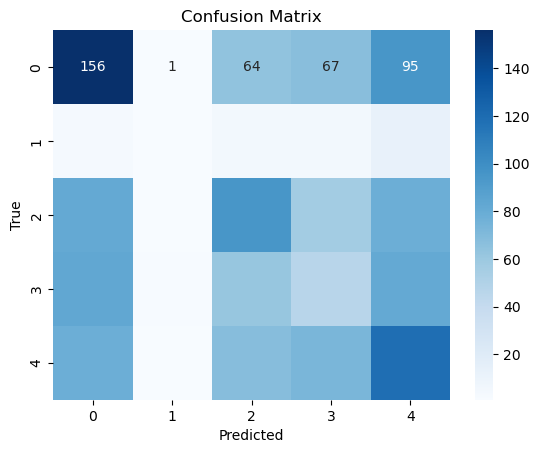

In [602]:
# Perform cross-validation to get predicted labels
y_pred = cross_val_predict(model, X, y, cv=5)

# Create a confusion matrix
cm = confusion_matrix(y, y_pred)

# Plotting the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [603]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)

Accuracy: 0.3805970149253731
Confusion Matrix:
 [[40  0  9 10 20]
 [ 0  1  0  0  2]
 [19  0 20  9 20]
 [17  0  9 14 16]
 [12  0 15  8 27]]
Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.51      0.48        79
           1       1.00      0.33      0.50         3
           2       0.38      0.29      0.33        68
           3       0.34      0.25      0.29        56
           4       0.32      0.44      0.37        62

    accuracy                           0.38       268
   macro avg       0.50      0.36      0.39       268
weighted avg       0.39      0.38      0.38       268



In [604]:
cm

array([[40,  0,  9, 10, 20],
       [ 0,  1,  0,  0,  2],
       [19,  0, 20,  9, 20],
       [17,  0,  9, 14, 16],
       [12,  0, 15,  8, 27]])

In [605]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Define a dictionary of models to evaluate
models = {
    "Logistic Regression": LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=2000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Support Vector Classifier": SVC(),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}

# Store results
results = {}

# Loop through models
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Cross-validation score
    cv_score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    
    # Fit on the test set
    y_pred = model.predict(X_test)
    
    # Store the results
    results[name] = {
        'CV Score Mean': cv_score.mean(),
        'Test Score': accuracy_score(y_test, y_pred),
        'Classification Report': classification_report(y_test, y_pred, output_dict=True)
    }

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results).T
print(results_df)

# Determine the best model based on test score
best_model_name = results_df['Test Score'].idxmax()
best_model_score = results_df['Test Score'].max()
print(f"The best model is: {best_model_name} with a test score of {best_model_score:.4f}")

/Users/jackguptill/anaconda3/envs/minimal_ds/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jackguptill/anaconda3/envs/minimal_ds/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

                          CV Score Mean Test Score  \
Logistic Regression            0.369746   0.347015   
Random Forest                  0.362291   0.376866   
Support Vector Classifier      0.283847   0.294776   
Decision Tree                  0.344556   0.347015   

                                                       Classification Report  
Logistic Regression        {'0': {'precision': 0.3875, 'recall': 0.392405...  
Random Forest              {'0': {'precision': 0.43010752688172044, 'reca...  
Support Vector Classifier  {'0': {'precision': 0.2947761194029851, 'recal...  
Decision Tree              {'0': {'precision': 0.49295774647887325, 'reca...  


/Users/jackguptill/anaconda3/envs/minimal_ds/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jackguptill/anaconda3/envs/minimal_ds/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jackguptill/anaconda3/envs/minimal_ds/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

TypeError: reduction operation 'argmax' not allowed for this dtype